# Step 1

In [4]:
import numpy as np

# ------------------------------------------------------------
# LOW-LEVEL STEP 1 (single image): RGB->HSV (uint8) + red mask
# ------------------------------------------------------------

def rgb_to_hsv_u8_pixel(R, G, B):
    """
    Convert one RGB pixel (0..255) to HSV in uint8 (0..255).
    Returns: (H, S, V) each in 0..255.
    
    Notes:
      - Integer approximation (HW-friendly).
      - Hue scaled to 0..255 representing 0..360 degrees.
    """
    # Find max/min among channels
    mx = R
    if G > mx: mx = G
    if B > mx: mx = B

    mn = R
    if G < mn: mn = G
    if B < mn: mn = B

    delta = mx - mn

    # Value is max channel
    V = mx

    # If black pixel => saturation=0, hue=0
    if mx == 0:
        return 0, 0, V

    # Saturation in 0..255
    S = (delta * 255) // mx

    # If gray pixel (no chroma) => hue=0
    if delta == 0:
        return 0, S, V

    # Hue in 0..255 (approx)
    # 43 ~= 256/6
    if mx == R:
        h = (43 * (G - B)) // delta
        if h < 0:
            h += 256
    elif mx == G:
        h = 85 + (43 * (B - R)) // delta
    else:
        h = 171 + (43 * (R - G)) // delta

    H = h & 0xFF
    return H, S, V


def red_mask_lowlevel_single(
    img_rgb_u8,
    hue_low1=0, hue_high1=10,
    hue_low2=245, hue_high2=255,
    sat_thresh_u8=64,   # ~0.25*255
    val_thresh_u8=64    # ~0.25*255
):
    """
    Create a red mask for ONE image.
    Input:
      img_rgb_u8: HxWx3 uint8
    Output:
      mask: HxW uint8 values {0,1}
    """
    H, W, C = img_rgb_u8.shape
    if C != 3:
        raise ValueError("Expected RGB image with 3 channels (HxWx3).")

    mask = np.zeros((H, W), dtype=np.uint8)

    for y in range(H):
        for x in range(W):
            # Read pixel as Python ints to avoid uint8 arithmetic issues
            R = int(img_rgb_u8[y, x, 0])
            G = int(img_rgb_u8[y, x, 1])
            B = int(img_rgb_u8[y, x, 2])

            # Convert RGB->HSV (uint8 domain)
            h, s, v = rgb_to_hsv_u8_pixel(R, G, B)

            # Red hue wrap-around check
            hue_ok = ((hue_low1 <= h <= hue_high1) or (hue_low2 <= h <= hue_high2))

            # Saturation/value thresholds
            sat_ok = (s >= sat_thresh_u8)
            val_ok = (v >= val_thresh_u8)

            # Final decision
            mask[y, x] = 1 if (hue_ok and sat_ok and val_ok) else 0

    return mask


# ------------------------------------------------------------
# LOW-LEVEL STEP 1 (batch): loop outside
# ------------------------------------------------------------

def step1_red_masks_batch(images_rgb_u8, **kwargs):
    """
    Run Step 1 on a LIST of RGB images.
    images_rgb_u8: list of HxWx3 uint8 images
    kwargs: forwarded to red_mask_lowlevel_single (thresholds, etc.)
    Returns: list of HxW uint8 masks
    """
    masks = []
    for img in images_rgb_u8:
        masks.append(red_mask_lowlevel_single(img, **kwargs))
    return masks


Debug:

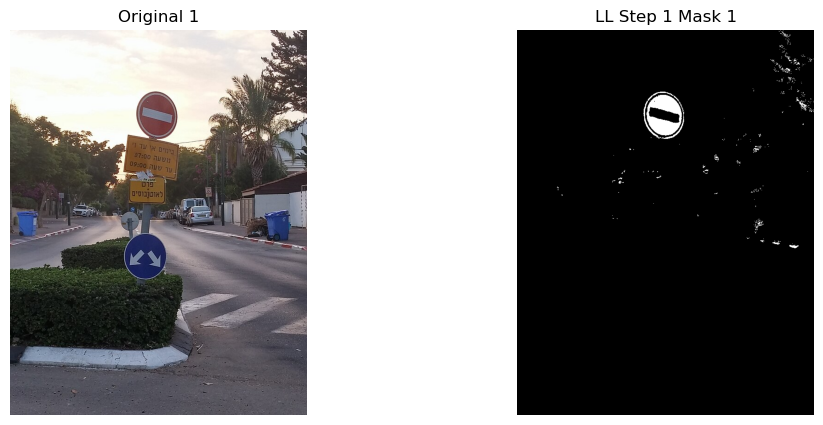

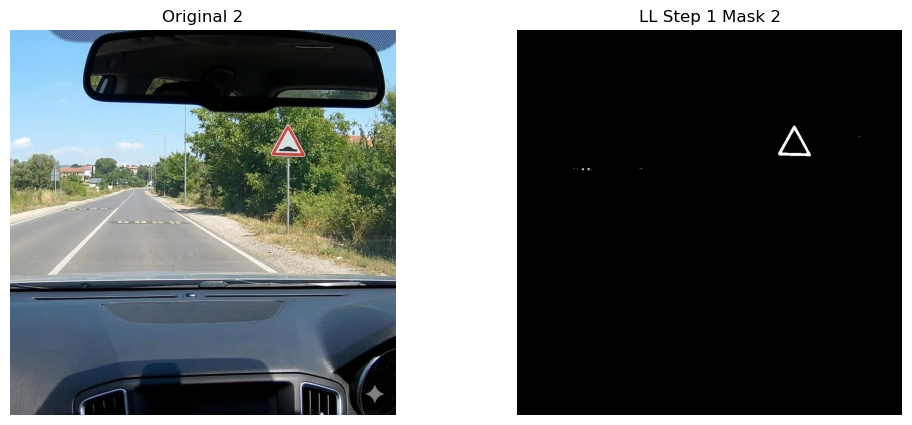

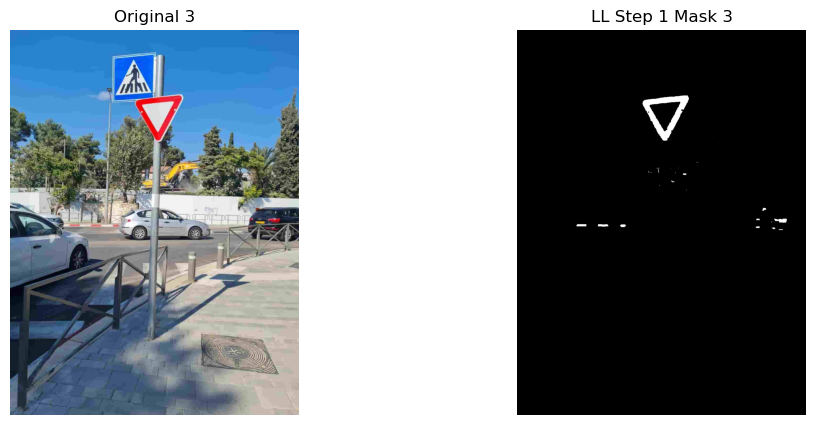

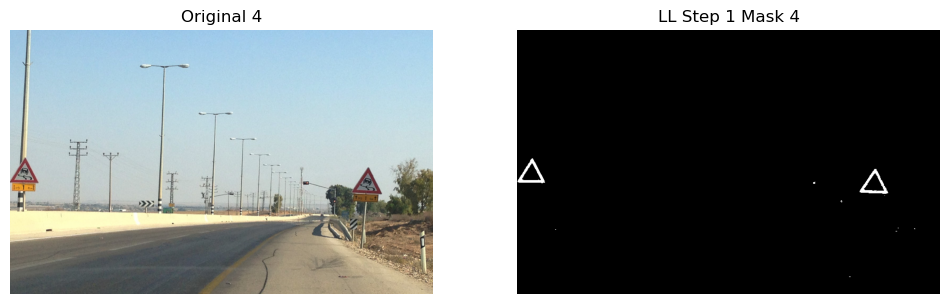

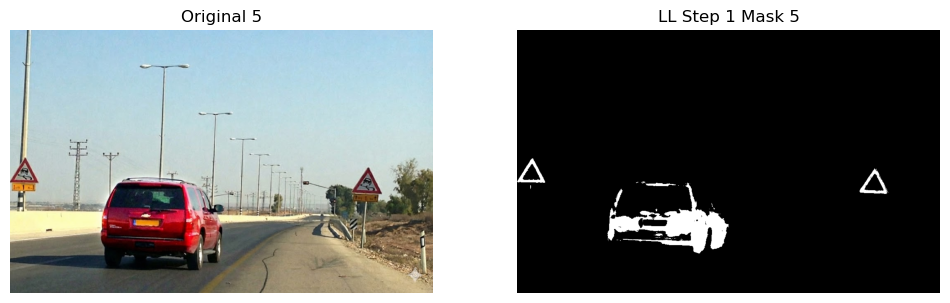

In [5]:
# ------------------------------------------------------------
# Load images from a directory (minimal, explicit)
# ------------------------------------------------------------

import os
from skimage import io

IMAGE_DIR = "real_pictures"

images = []

for fname in sorted(os.listdir(IMAGE_DIR)):
    if fname.lower().endswith((".jpg", ".jpeg", ".png")):
        img = io.imread(os.path.join(IMAGE_DIR, fname))

        # Ensure RGB uint8
        if img.ndim == 2:  # grayscale -> RGB
            img = np.stack([img, img, img], axis=2)
        if img.shape[2] == 4:  # RGBA -> RGB
            img = img[:, :, :3]
        if img.dtype != np.uint8:
            img = img.astype(np.uint8)

        images.append(img)

masks_ll = step1_red_masks_batch(images)

# Quick visualization
import matplotlib.pyplot as plt
for i, (img, m) in enumerate(zip(images, masks_ll), start=1):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.title(f"Original {i}"); plt.axis("off")
    plt.subplot(1, 2, 2); plt.imshow(m, cmap="gray"); plt.title(f"LL Step 1 Mask {i}"); plt.axis("off")
    plt.show()


# step 2 - LOW-LEVEL MORPHOLOGY

In [6]:

# ------------------------------------------------------------
# Step 1.5 (single mask): morphology (closing) + optional hole filling
# ------------------------------------------------------------

import numpy as np
from collections import deque

# ------------------------------------------------------------
# Helpers: disk footprint (matches skimage.morphology.disk behavior)
# ------------------------------------------------------------

def make_disk_offsets(radius):
    """
    Create (dy,dx) offsets for a flat disk footprint:
    dy^2 + dx^2 <= radius^2
    """
    offs = []
    r2 = radius * radius
    for dy in range(-radius, radius + 1):
        for dx in range(-radius, radius + 1):
            if dy*dy + dx*dx <= r2:
                offs.append((dy, dx))
    return offs


# ------------------------------------------------------------
# Binary morphology with disk footprint (0/1 masks)
# ------------------------------------------------------------

def binary_dilate_disk_single(mask_u8, radius):
    """
    Binary dilation using a disk footprint.
    Output pixel is 1 if ANY neighbor under the disk is 1.
    Outside-image pixels are treated as 0.
    """
    H, W = mask_u8.shape
    out = np.zeros((H, W), dtype=np.uint8)
    offs = make_disk_offsets(radius)

    for y in range(H):
        for x in range(W):
            val = 0
            for dy, dx in offs:
                yy = y + dy
                xx = x + dx
                if 0 <= yy < H and 0 <= xx < W:
                    if mask_u8[yy, xx] != 0:
                        val = 1
                        break
            out[y, x] = val

    return out


def binary_erode_disk_single(mask_u8, radius):
    """
    Binary erosion using a disk footprint.
    Output pixel is 1 only if ALL neighbors under the disk are 1.
    Outside-image pixels are treated as 0 (so erosion near borders tends to shrink).
    """
    H, W = mask_u8.shape
    out = np.zeros((H, W), dtype=np.uint8)
    offs = make_disk_offsets(radius)

    for y in range(H):
        for x in range(W):
            val = 1
            for dy, dx in offs:
                yy = y + dy
                xx = x + dx
                if not (0 <= yy < H and 0 <= xx < W):
                    val = 0
                    break
                if mask_u8[yy, xx] == 0:
                    val = 0
                    break
            out[y, x] = val

    return out


def binary_close_disk_single(mask_u8, radius):
    """
    Closing = dilation followed by erosion (same disk radius).
    Matches the structure of:
      closed = erosion(dilation(mask, disk(r)), disk(r))
    """
    dil = binary_dilate_disk_single(mask_u8, radius)
    clo = binary_erode_disk_single(dil, radius)
    return clo


# ------------------------------------------------------------
# Connected components (low-level BFS) with pixel collection
# ------------------------------------------------------------

def collect_components(mask_u8, target_value=1, connectivity=4):
    """
    Collect connected components for pixels == target_value.
    Returns a list of components, each component is:
      {
        "area": int,
        "touches_border": bool,
        "pixels": list of linear indices (y*W + x)
      }
    connectivity: 4 or 8
    """
    H, W = mask_u8.shape
    visited = np.zeros((H, W), dtype=np.uint8)
    comps = []

    if connectivity == 4:
        nbrs = [(-1,0),(1,0),(0,-1),(0,1)]
    else:
        nbrs = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]

    for y0 in range(H):
        for x0 in range(W):
            if mask_u8[y0, x0] != target_value or visited[y0, x0] != 0:
                continue

            q = deque()
            q.append((y0, x0))
            visited[y0, x0] = 1

            pixels = []
            area = 0
            touches_border = False

            while q:
                y, x = q.popleft()
                area += 1
                pixels.append(y * W + x)

                if y == 0 or x == 0 or y == H-1 or x == W-1:
                    touches_border = True

                for dy, dx in nbrs:
                    yy = y + dy
                    xx = x + dx
                    if 0 <= yy < H and 0 <= xx < W:
                        if visited[yy, xx] == 0 and mask_u8[yy, xx] == target_value:
                            visited[yy, xx] = 1
                            q.append((yy, xx))

            comps.append({
                "area": area,
                "touches_border": touches_border,
                "pixels": pixels
            })

    return comps


# ------------------------------------------------------------
# High-level-equivalent hole filling and small-foreground removal
# ------------------------------------------------------------

def fill_enclosed_holes_like_highlevel(mask_u8, min_hole_size=300, connectivity=4):
    """
    Mimics the high-level approach:
      inv = 1 - mask
      label inv-components (holes/background)
      fill only components that:
        - do NOT touch border
        - area >= min_hole_size
    """
    H, W = mask_u8.shape
    inv = (1 - mask_u8).astype(np.uint8)

    comps = collect_components(inv, target_value=1, connectivity=connectivity)
    filled = mask_u8.copy()

    for comp in comps:
        if comp["touches_border"]:
            continue
        if comp["area"] < min_hole_size:
            continue

        # Fill this enclosed hole
        for idx in comp["pixels"]:
            y = idx // W
            x = idx % W
            filled[y, x] = 1

    return filled


def remove_small_foreground_like_highlevel(mask_u8, min_foreground_size=1000, connectivity=4):
    """
    Mimics the high-level approach:
      label foreground components and delete those with area < min_foreground_size
    """
    H, W = mask_u8.shape
    comps = collect_components(mask_u8, target_value=1, connectivity=connectivity)
    out = mask_u8.copy()

    for comp in comps:
        if comp["area"] < min_foreground_size:
            for idx in comp["pixels"]:
                y = idx // W
                x = idx % W
                out[y, x] = 0

    return out


def solidify_mask_lowlevel_single(mask_u8,
                                 close_radius=3,
                                 min_hole_size=300,
                                 min_foreground_size=1000,
                                 smooth_radius=0,
                                 connectivity=4):
    """
    Low-level equivalent of your high-level 'solidify_mask':
      1) closing with disk(close_radius)
      2) fill enclosed holes (min_hole_size)
      3) remove small foreground components (min_foreground_size)
      4) optional smoothing closing with disk(smooth_radius)
    """
    # 1) Closing (disk)
    closed = binary_close_disk_single(mask_u8, radius=close_radius)

    # 2) Fill enclosed holes (size-filtered)
    filled = fill_enclosed_holes_like_highlevel(
        closed, min_hole_size=min_hole_size, connectivity=connectivity
    )

    # 3) Remove small foreground components
    cleaned = remove_small_foreground_like_highlevel(
        filled, min_foreground_size=min_foreground_size, connectivity=connectivity
    )

    # 4) Optional smoothing (same style closing)
    if smooth_radius and smooth_radius > 0:
        cleaned = binary_close_disk_single(cleaned, radius=smooth_radius)

    return cleaned


def solidify_mask_lowlevel_batch(masks_u8, **kwargs):
    """
    Batch wrapper: run solidify_mask_lowlevel_single on a list of masks.
    """
    out = []
    for m in masks_u8:
        out.append(solidify_mask_lowlevel_single(m, **kwargs))
    return out




DEBUG:

Image 1: step1 ones=6124, step1.5 ones=7012
Image 2: step1 ones=1906, step1.5 ones=3931
Image 3: step1 ones=14583, step1.5 ones=20558
Image 4: step1 ones=1455, step1.5 ones=2697
Image 5: step1 ones=19423, step1.5 ones=22949
Showing 5 images...


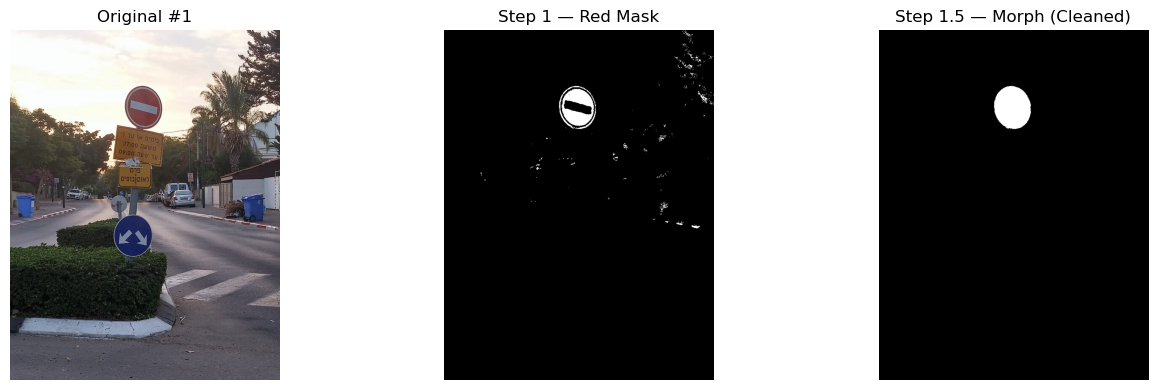

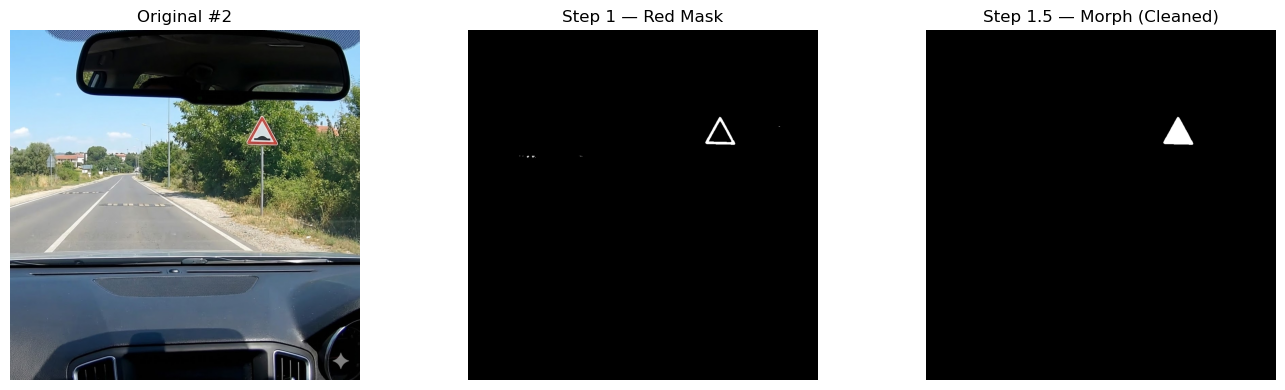

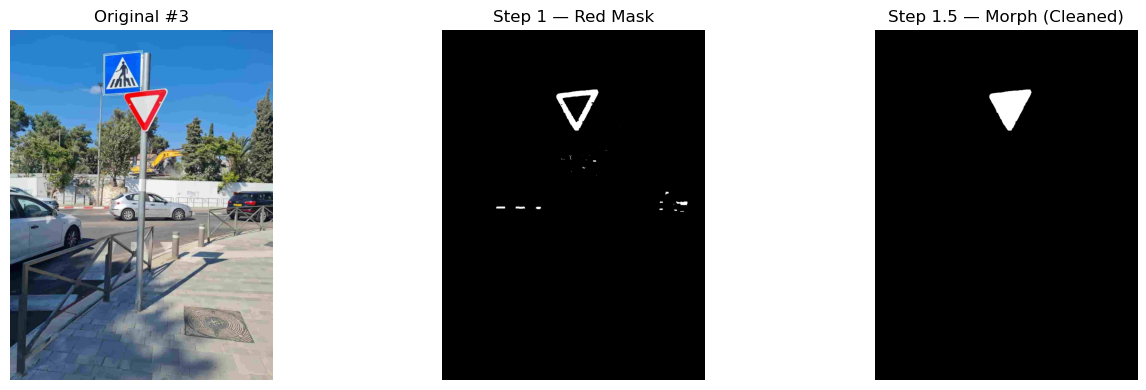

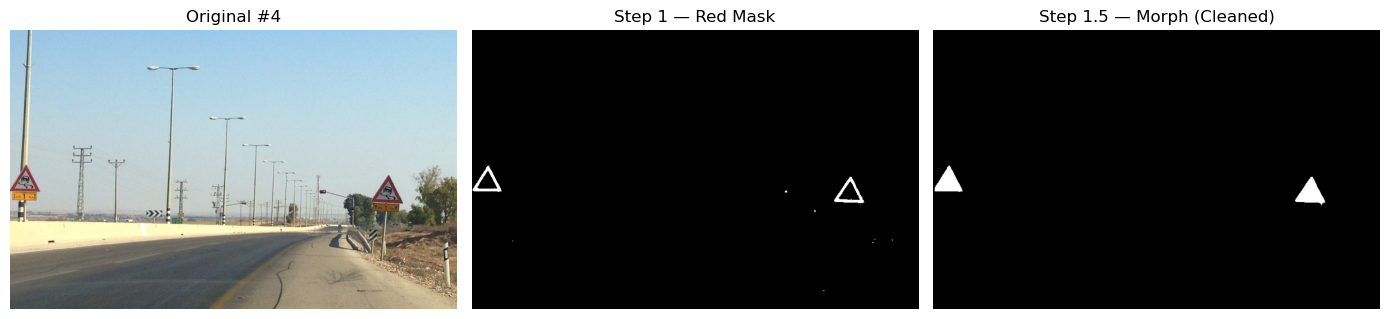

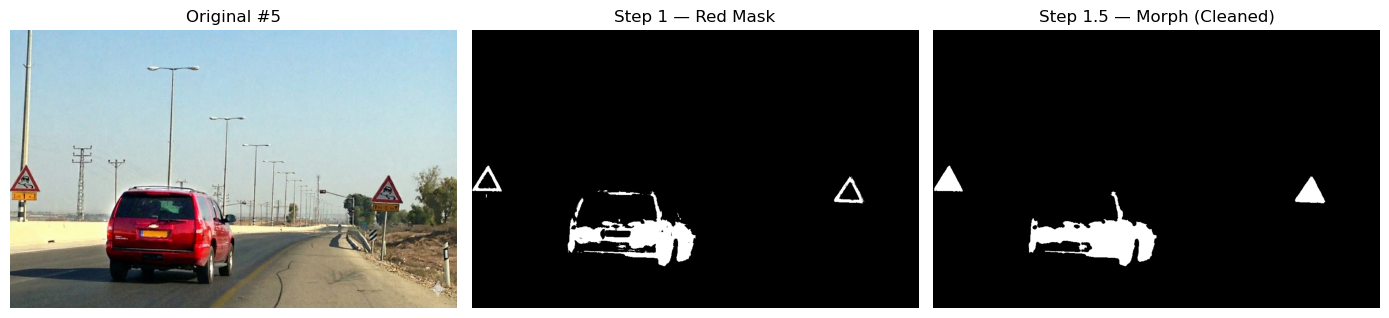

In [7]:
# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------

def show_step1_and_step15(images, masks_step1, masks_step15, max_show=None):
    """
    Display per image:
      - Original RGB
      - Step 1 mask (0/1)
      - Step 1.5 mask (0/1)
    """
    n = len(images)
    if max_show is not None:
        n = min(n, max_show)

    print(f"Showing {n} images...")  # sanity print

    for i in range(n):
        img = images[i]
        m1 = masks_step1[i]
        m15 = masks_step15[i]

        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f"Original #{i+1}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(m1, cmap="gray", vmin=0, vmax=1)
        plt.title("Step 1 — Red Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(m15, cmap="gray", vmin=0, vmax=1)
        plt.title("Step 1.5 — Morph (Cleaned)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# RUN (edit IMAGE_DIR if needed)
# ------------------------------------------------------------


masks_step1 = step1_red_masks_batch(images)

# Step 1.5 (HIGHLEVEL-like): closing(disk) + fill enclosed holes + remove small FG
masks_step15 = solidify_mask_lowlevel_batch(
    masks_step1,
    close_radius=3,
    min_hole_size=300,
    min_foreground_size=1000,
    smooth_radius=0,
    connectivity=4
)

# Optional sanity stats (helps see if noise is being removed)
for i in range(min(5, len(masks_step1))):
    s1 = int(masks_step1[i].sum())
    s2 = int(masks_step15[i].sum())
    print(f"Image {i+1}: step1 ones={s1}, step1.5 ones={s2}")

# Display
show_step1_and_step15(images, masks_step1, masks_step15, max_show=10)


# Step 2/4 — Connected Components + Shape Metrics + Best ROI selection

Showing 5 images...
Image 1: shape=circle area=7012 per=270 circ=1.209 bbox=(133, 272, 234, 359)


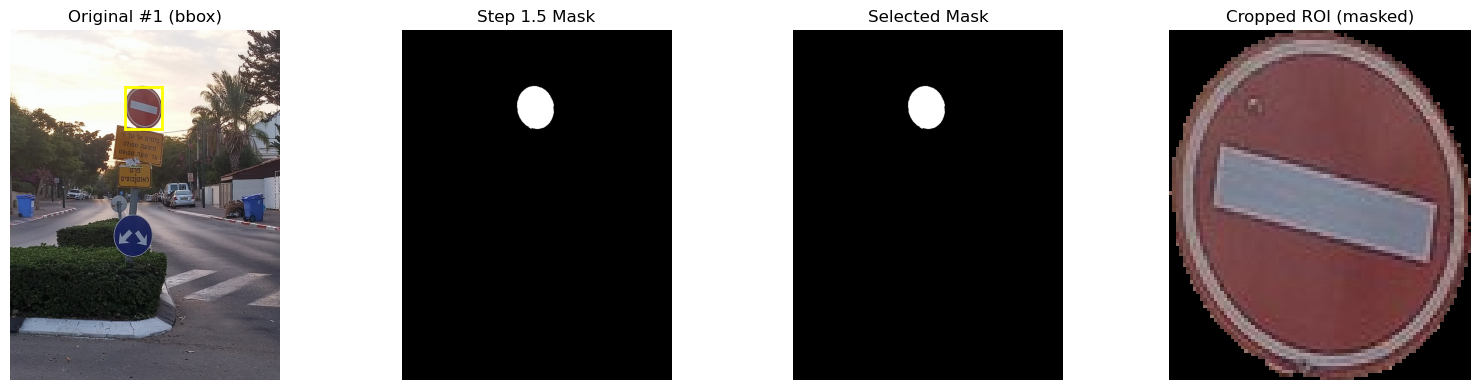

Image 2: shape=circle area=3931 per=244 circ=0.830 bbox=(254, 694, 335, 781)


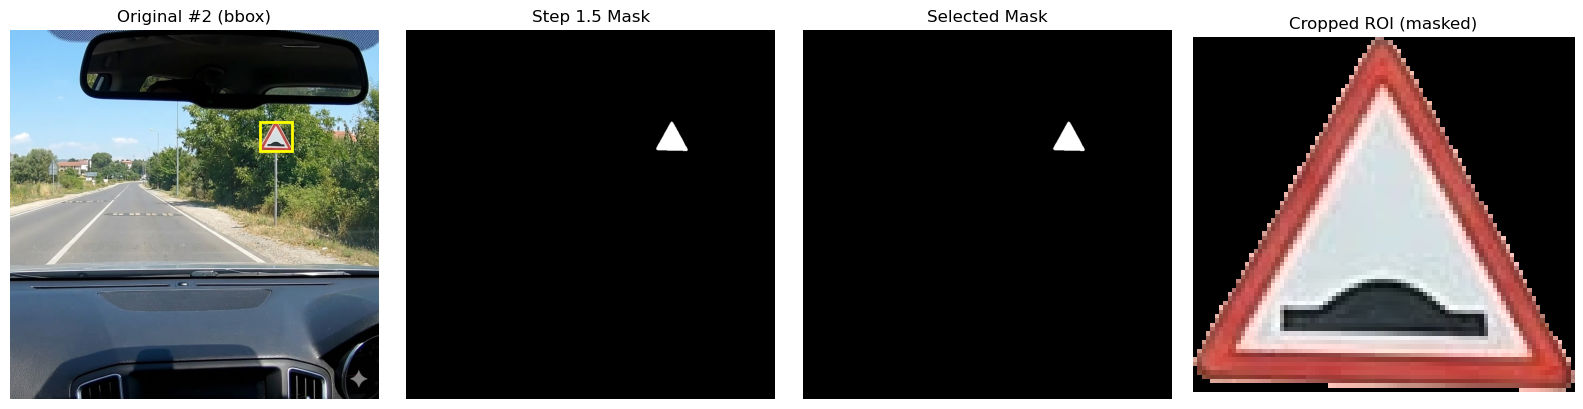

Image 3: shape=circle area=20558 per=566 circ=0.806 bbox=(272, 521, 459, 713)


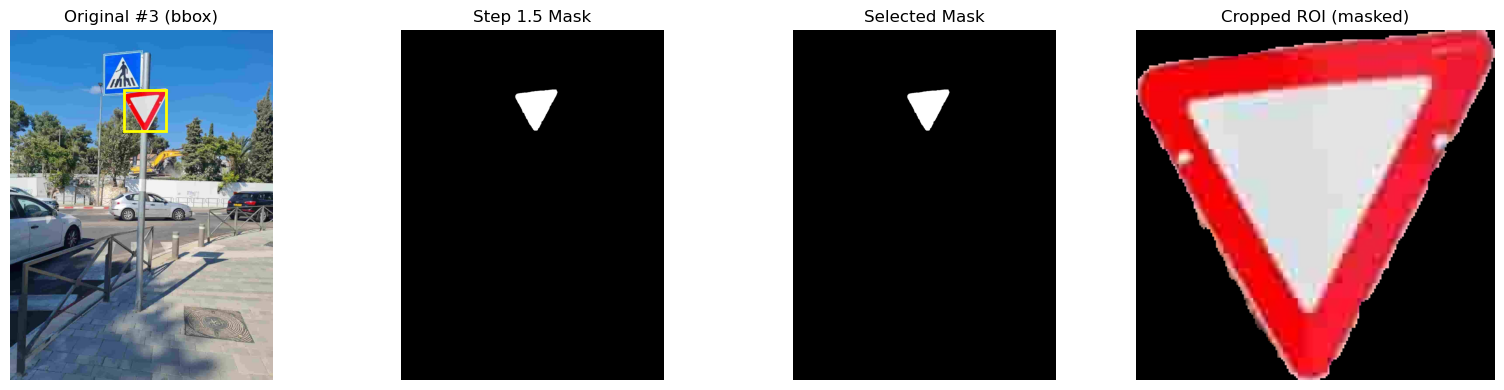

Image 4: shape=circle area=1393 per=146 circ=0.821 bbox=(264, 648, 314, 701)


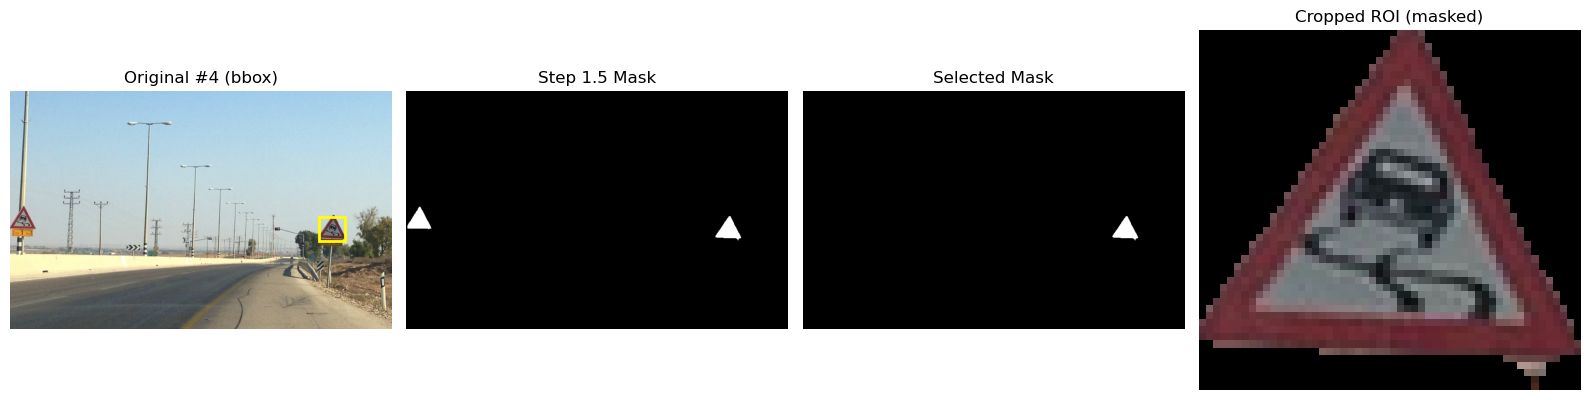

Image 5: shape=circle area=2346 per=187 circ=0.843 bbox=(335, 829, 396, 898)


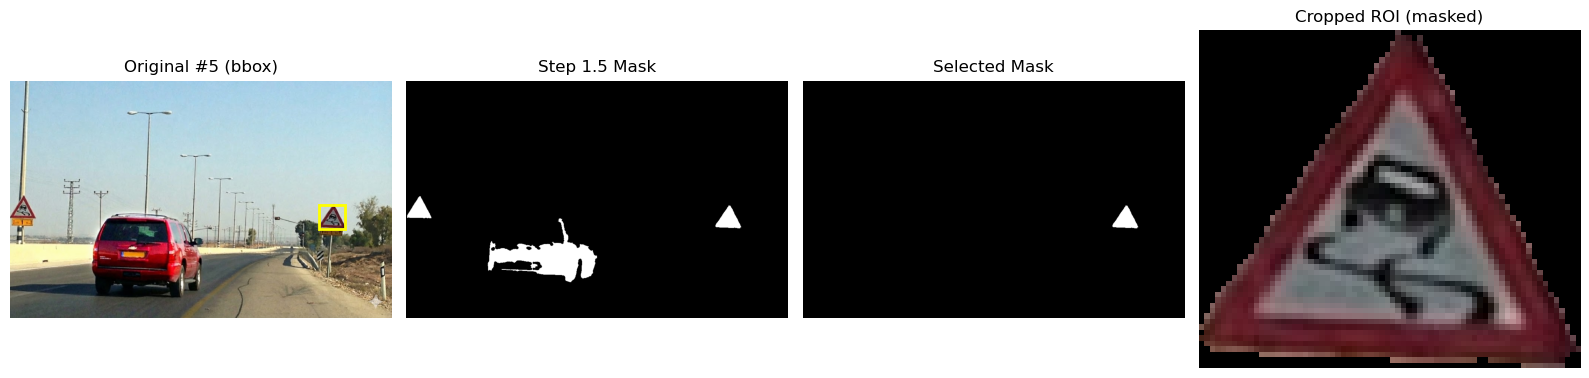

In [ ]:
# ============================================================
# NEXT STEP (after Step 1.5):
# Step 2/4 — Connected Components + Shape Metrics + Best ROI selection
#
# Dependencies:
#   - images                : list of RGB uint8 images (HxWx3)
#   - masks_step15          : list of binary uint8 masks (HxW, values {0,1})
#   - collect_components    : BFS CC function from your existing code
#
# Outputs:
#   - selected_masks        : list of best-component masks (HxW uint8) or None
#   - selected_bboxes       : list of (ymin,xmin,ymax,xmax) inclusive or None
#   - selected_stats        : list of dict stats per image
#
# Includes visualization at the end.
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ------------------------------------------------------------
# Component stats (bbox, perimeter, circularity)
# ------------------------------------------------------------

def bbox_from_pixels(pixels, W):
    """
    Compute inclusive bbox (ymin,xmin,ymax,xmax) from a list of linear indices.
    """
    ymin = 10**9
    xmin = 10**9
    ymax = -1
    xmax = -1

    for idx in pixels:
        y = idx // W
        x = idx % W
        if y < ymin: ymin = y
        if x < xmin: xmin = x
        if y > ymax: ymax = y
        if x > xmax: xmax = x

    return (ymin, xmin, ymax, xmax)


def perimeter_4_from_pixels(mask_u8, pixels, H, W):
    """
    Approximate 4-neighborhood perimeter:
    Count a pixel as boundary if it has any 4-neighbor that is background (0) or out-of-bounds.
    """
    per = 0
    for idx in pixels:
        y = idx // W
        x = idx % W

        # If any of the 4-neighbors is outside or 0 => boundary pixel
        if y == 0 or mask_u8[y - 1, x] == 0:
            per += 1
            continue
        if y == H - 1 or mask_u8[y + 1, x] == 0:
            per += 1
            continue
        if x == 0 or mask_u8[y, x - 1] == 0:
            per += 1
            continue
        if x == W - 1 or mask_u8[y, x + 1] == 0:
            per += 1
            continue

    return per


def circularity(area, perimeter, eps=1e-8):
    """
    Circularity = 4*pi*Area / Perimeter^2
    Range: (0..1] for ideal circle (with perfect continuous boundary).
    """
    if perimeter <= 0:
        return 0.0
    return float((4.0 * np.pi * area) / ((perimeter * perimeter) + eps))


def mask_from_pixels(pixels, H, W):
    """
    Build a binary mask (HxW uint8) from linear indices.
    """
    m = np.zeros((H, W), dtype=np.uint8)
    for idx in pixels:
        y = idx // W
        x = idx % W
        m[y, x] = 1
    return m


# ------------------------------------------------------------
# Best component selection (matches your earlier high-level logic)
# ------------------------------------------------------------

def select_best_component_single(mask_u8,
                                 min_area=300,
                                 triangle_threshold=0.55,
                                 circle_threshold=0.70,
                                 connectivity=4):
    """
    Find connected components, compute stats (area, perimeter, circularity),
    keep components that look like triangle/circle by circularity thresholds,
    and return the largest valid component.

    Returns:
      best_mask (HxW uint8) or None
      best_bbox (ymin,xmin,ymax,xmax) inclusive or None
      best_info dict with stats (or None)
    """
    H, W = mask_u8.shape

    comps = collect_components(mask_u8, target_value=1, connectivity=connectivity)

    valid = []
    for comp_id, comp in enumerate(comps, start=1):
        area = int(comp["area"])
        if area < min_area:
            continue

        pixels = comp["pixels"]
        bbox = bbox_from_pixels(pixels, W)
        per = perimeter_4_from_pixels(mask_u8, pixels, H, W)
        circ = circularity(area, per)

        # Same rule style as you used before
        shape = None
        if triangle_threshold < circ <= circle_threshold:
            shape = "triangle"
        elif circ > circle_threshold:
            shape = "circle"
        else:
            continue

        valid.append({
            "area": area,
            "perimeter": int(per),
            "circularity": float(circ),
            "bbox": bbox,
            "shape": shape,
            "pixels": pixels
        })

    if len(valid) == 0:
        return None, None, None

    # Pick the largest valid component by area
    best = max(valid, key=lambda d: d["area"])
    best_mask = mask_from_pixels(best["pixels"], H, W)

    return best_mask, best["bbox"], best


def select_best_components_batch(masks_u8, **kwargs):
    """
    Batch wrapper over a list of masks.
    """
    best_masks = []
    best_bboxes = []
    best_infos = []

    for m in masks_u8:
        bm, bb, info = select_best_component_single(m, **kwargs)
        best_masks.append(bm)
        best_bboxes.append(bb)
        best_infos.append(info)

    return best_masks, best_bboxes, best_infos


# ------------------------------------------------------------
# ROI extraction + visualization
# ------------------------------------------------------------

def crop_roi_with_mask(img_rgb_u8, best_mask_u8, bbox):
    """
    Crop ROI from original RGB using inclusive bbox.
    Optionally apply best_mask inside ROI (mask outside object -> 0).
    """
    ymin, xmin, ymax, xmax = bbox
    ymin = max(0, ymin); xmin = max(0, xmin)
    ymax = min(img_rgb_u8.shape[0] - 1, ymax)
    xmax = min(img_rgb_u8.shape[1] - 1, xmax)

    roi = img_rgb_u8[ymin:ymax+1, xmin:xmax+1].copy()

    if best_mask_u8 is not None:
        m = best_mask_u8[ymin:ymax+1, xmin:xmax+1]
        roi = roi * m[..., None].astype(roi.dtype)

    return roi


def show_step15_and_selection(images, masks_step15, best_masks, best_bboxes, best_infos, max_show=10):
    """
    Display per image:
      - Original + bbox overlay
      - Step 1.5 mask
      - Selected component mask
      - Cropped masked ROI
    """
    n = min(len(images), max_show)

    print(f"Showing {n} images...")

    for i in range(n):
        img = images[i]
        m15 = masks_step15[i]
        bm = best_masks[i]
        bb = best_bboxes[i]
        info = best_infos[i]

        # Text summary
        if info is None:
            print(f"Image {i+1}: NO VALID COMPONENT (min_area/shape thresholds failed)")
        else:
            print(
                f"Image {i+1}: shape={info['shape']} area={info['area']} "
                f"per={info['perimeter']} circ={info['circularity']:.3f} bbox={info['bbox']}"
            )

        plt.figure(figsize=(16, 4))

        # 1) Original with bbox
        ax1 = plt.subplot(1, 4, 1)
        ax1.imshow(img)
        ax1.set_title(f"Original #{i+1} (bbox)")
        ax1.axis("off")
        if bb is not None:
            ymin, xmin, ymax, xmax = bb
            rect = patches.Rectangle(
                (xmin, ymin),
                (xmax - xmin + 1),
                (ymax - ymin + 1),
                linewidth=2,
                edgecolor="yellow",
                facecolor="none"
            )
            ax1.add_patch(rect)

        # 2) Step 1.5 mask
        ax2 = plt.subplot(1, 4, 2)
        ax2.imshow(m15, cmap="gray", vmin=0, vmax=1)
        ax2.set_title("Step 1.5 Mask")
        ax2.axis("off")

        # 3) Selected component mask
        ax3 = plt.subplot(1, 4, 3)
        if bm is None:
            ax3.imshow(np.zeros_like(m15), cmap="gray", vmin=0, vmax=1)
            ax3.set_title("Selected Mask (none)")
        else:
            ax3.imshow(bm, cmap="gray", vmin=0, vmax=1)
            ax3.set_title("Selected Mask")
        ax3.axis("off")

        # 4) Cropped ROI (masked)
        ax4 = plt.subplot(1, 4, 4)
        if bm is None or bb is None:
            ax4.imshow(np.zeros((32, 32, 3), dtype=np.uint8))
            ax4.set_title("Cropped ROI (none)")
        else:
            roi = crop_roi_with_mask(img, bm, bb)
            ax4.imshow(roi)
            ax4.set_title("Cropped ROI (masked)")
        ax4.axis("off")

        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# RUN THIS BLOCK (after you already computed masks_step15)
# ------------------------------------------------------------

best_masks, best_bboxes, best_infos = select_best_components_batch(
    masks_step15,
    min_area=300,
    triangle_threshold=0.55,
    circle_threshold=0.70,
    connectivity=4
)

show_step15_and_selection(
    images,
    masks_step15,
    best_masks,
    best_bboxes,
    best_infos,
    max_show=10
)


# next step

Loaded templates: ['rsz_123-1', 'rsz_126-1', 'rsz_136-1', 'rsz_141', 'rsz_141_block', 'rsz_144-1', 'rsz_144-1_copy', 'rsz_1s_30', 'rsz_301_optimized', 'rsz_301_optimized_black', 'rsz_302_optimized', 'rsz_402_optimized', 'rsz_402_optimized_black', 'rsz_s_40']
Image 1: best='rsz_402_optimized_black' SAD=0.149 => pred='rsz_402_optimized_black'
Image 2: best='rsz_144-1_copy' SAD=0.143 => pred='rsz_144-1_copy'
Image 3: best='rsz_301_optimized_black' SAD=0.120 => pred='rsz_301_optimized_black'
Image 4: best='rsz_141_block' SAD=0.195 => pred='rsz_141_block'
Image 5: best='rsz_141_block' SAD=0.176 => pred='rsz_141_block'

Predictions:
Image 1: pred=rsz_402_optimized_black score=0.149
Image 2: pred=rsz_144-1_copy score=0.143
Image 3: pred=rsz_301_optimized_black score=0.120
Image 4: pred=rsz_141_block score=0.195
Image 5: pred=rsz_141_block score=0.176
Showing 5 matches...


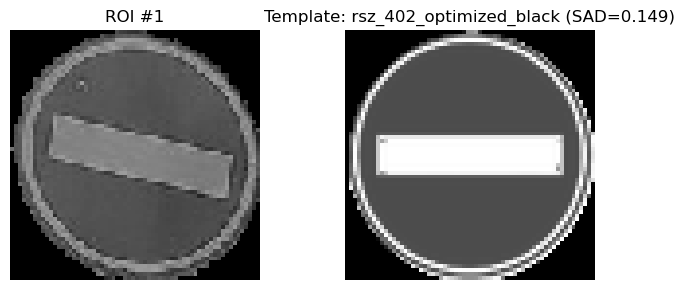

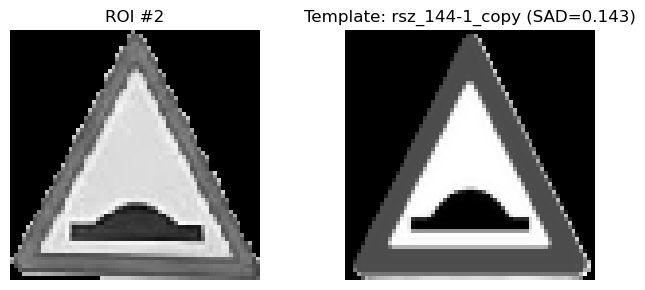

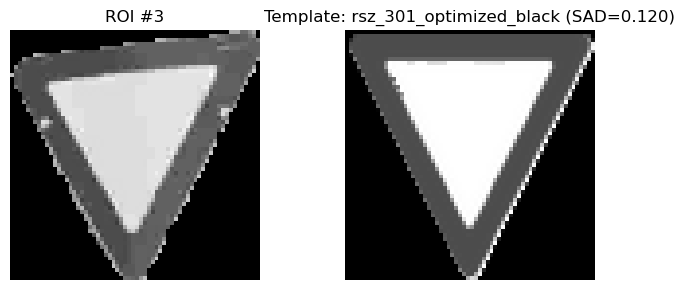

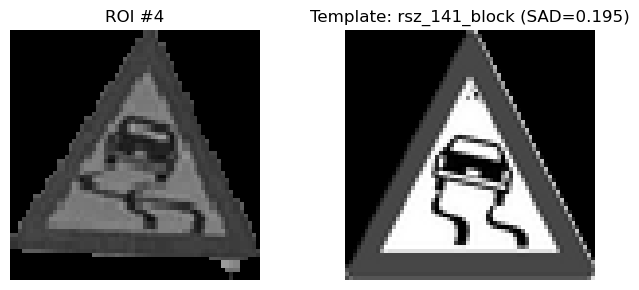

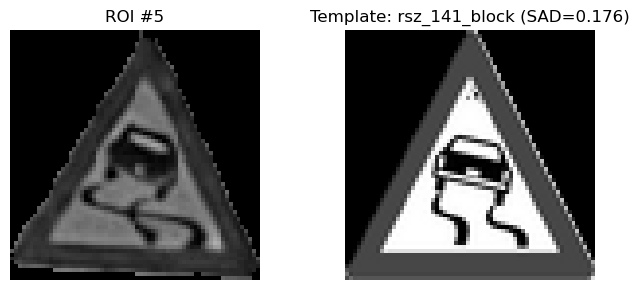

In [ ]:
# ============================================================
# NEXT STEP:
# Step 5 — Resize ROI to fixed size (LOW-LEVEL NN resize)
# Step 6 — BASIC Template Matching (LOW-LEVEL SAD on grayscale)
#
# Depends on existing variables from previous blocks:
#   - images        : list of RGB uint8 images (HxWx3)
#   - best_masks    : list of best component masks (HxW uint8) or None
#   - best_bboxes   : list of (ymin,xmin,ymax,xmax) inclusive or None
#   - crop_roi_with_mask(img, best_mask, bbox)  (from previous code)
#
# Produces:
#   - resized_rois_rgb : list of 64x64 RGB uint8 (or None)
#   - pred_labels      : list of predicted template labels (or "no_sign"/"unknown")
#   - best_scores      : list of normalized SAD scores (lower is better)
#
# Includes visualization at the end.
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

TARGET_H = 64
TARGET_W = 64
TEMPLATE_DIR = "Templates"

# ------------------------------------------------------------
# Low-level helpers: grayscale + nearest-neighbor resize
# ------------------------------------------------------------

def rgb_to_gray_u8(img_rgb_u8):
    """
    Convert RGB uint8 image to grayscale uint8 using integer approximation.
    Gray ~= 0.299R + 0.587G + 0.114B
    Implemented as: (77*R + 150*G + 29*B) >> 8
    """
    H, W, _ = img_rgb_u8.shape
    out = np.zeros((H, W), dtype=np.uint8)
    for y in range(H):
        for x in range(W):
            R = int(img_rgb_u8[y, x, 0])
            G = int(img_rgb_u8[y, x, 1])
            B = int(img_rgb_u8[y, x, 2])
            gray = (77 * R + 150 * G + 29 * B) >> 8
            if gray < 0: gray = 0
            if gray > 255: gray = 255
            out[y, x] = gray
    return out


def resize_nn_gray_u8(img_u8, out_h=TARGET_H, out_w=TARGET_W):
    """
    Nearest-neighbor resize for a single-channel uint8 image.
    """
    in_h, in_w = img_u8.shape
    out = np.zeros((out_h, out_w), dtype=np.uint8)

    for y in range(out_h):
        sy = (y * in_h) // out_h
        if sy >= in_h: sy = in_h - 1
        for x in range(out_w):
            sx = (x * in_w) // out_w
            if sx >= in_w: sx = in_w - 1
            out[y, x] = img_u8[sy, sx]

    return out


def resize_nn_rgb_u8(img_rgb_u8, out_h=TARGET_H, out_w=TARGET_W):
    """
    Nearest-neighbor resize for an RGB uint8 image.
    """
    in_h, in_w, _ = img_rgb_u8.shape
    out = np.zeros((out_h, out_w, 3), dtype=np.uint8)

    for y in range(out_h):
        sy = (y * in_h) // out_h
        if sy >= in_h: sy = in_h - 1
        for x in range(out_w):
            sx = (x * in_w) // out_w
            if sx >= in_w: sx = in_w - 1
            out[y, x, 0] = img_rgb_u8[sy, sx, 0]
            out[y, x, 1] = img_rgb_u8[sy, sx, 1]
            out[y, x, 2] = img_rgb_u8[sy, sx, 2]

    return out


# ------------------------------------------------------------
# Step 5: ROI crop + mask + resize (batch)
# ------------------------------------------------------------

def build_resized_rois_batch(images, best_masks, best_bboxes, out_h=TARGET_H, out_w=TARGET_W):
    """
    For each image:
      - If bbox/mask missing => None
      - Crop ROI from original RGB
      - Apply component mask inside ROI
      - Resize to fixed out_h x out_w (NN)
    Returns list of resized RGB rois (or None).
    """
    resized_rois = []

    for i in range(len(images)):
        img = images[i]
        bm = best_masks[i]
        bb = best_bboxes[i]

        if bm is None or bb is None:
            resized_rois.append(None)
            continue

        roi = crop_roi_with_mask(img, bm, bb)          # cropped + masked (RGB)
        roi64 = resize_nn_rgb_u8(roi, out_h, out_w)    # 64x64 RGB
        resized_rois.append(roi64)

    return resized_rois


# ------------------------------------------------------------
# Step 6: BASIC Template Matching (SAD on grayscale)
# ------------------------------------------------------------

def load_templates_gray_u8(template_dir=TEMPLATE_DIR, out_h=TARGET_H, out_w=TARGET_W):
    """
    Load templates from a folder, convert to grayscale uint8, resize to target size (NN).
    Returns dict: label -> (out_h,out_w) uint8
    """
    if not os.path.isdir(template_dir):
        raise FileNotFoundError(f"Folder '{template_dir}' not found next to the notebook.")

    valid_ext = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    templates = {}

    for fname in sorted(os.listdir(template_dir)):
        if not fname.lower().endswith(valid_ext):
            continue

        label = os.path.splitext(fname)[0]
        img = io.imread(os.path.join(template_dir, fname))

        # Ensure RGB for grayscale conversion
        if img.ndim == 2:
            img_rgb = np.stack([img, img, img], axis=2).astype(np.uint8)
        else:
            if img.shape[2] == 4:
                img = img[:, :, :3]
            img_rgb = img.astype(np.uint8)

        g = rgb_to_gray_u8(img_rgb)
        g64 = resize_nn_gray_u8(g, out_h, out_w)
        templates[label] = g64

    if len(templates) == 0:
        raise RuntimeError(f"No templates found in '{template_dir}'.")

    print("Loaded templates:", list(templates.keys()))
    return templates


def sad_score_norm_u8(a_u8, b_u8):
    """
    Normalized SAD (sum of absolute differences) for same-size uint8 arrays.
    Returns score in [0..1], lower is better.
      score = sum(|a-b|) / (255 * H * W)
    """
    H, W = a_u8.shape
    s = 0
    for y in range(H):
        for x in range(W):
            da = int(a_u8[y, x]) - int(b_u8[y, x])
            if da < 0: da = -da
            s += da
    denom = 255.0 * H * W
    return float(s) / denom if denom > 0 else 1.0


def match_rois_to_templates(resized_rois_rgb, templates_gray_u8, match_threshold=0.30):
    """
    For each ROI:
      - If None => "no_sign"
      - Convert ROI to gray, compute SAD vs each template
      - Pick minimal SAD
      - If best SAD <= threshold => predicted label else "unknown"
    """
    pred_labels = []
    best_scores = []
    best_template_labels = []

    labels = list(templates_gray_u8.keys())

    for i, roi_rgb in enumerate(resized_rois_rgb, start=1):
        if roi_rgb is None:
            pred_labels.append("no_sign")
            best_scores.append(None)
            best_template_labels.append(None)
            continue

        roi_g = rgb_to_gray_u8(roi_rgb)

        best_lab = None
        best_sc = 1e9

        for lab in labels:
            sc = sad_score_norm_u8(roi_g, templates_gray_u8[lab])
            if sc < best_sc:
                best_sc = sc
                best_lab = lab

        pred = best_lab if best_sc <= match_threshold else "unknown"

        pred_labels.append(pred)
        best_scores.append(best_sc)
        best_template_labels.append(best_lab)

        print(f"Image {i}: best='{best_lab}' SAD={best_sc:.3f} => pred='{pred}'")

    return pred_labels, best_scores, best_template_labels


# ------------------------------------------------------------
# Visualization: resized ROI vs best template
# ------------------------------------------------------------

def show_template_matching(resized_rois_rgb, templates_gray_u8, pred_labels, best_scores, max_show=10):
    """
    Show ROI (gray) vs predicted template (gray).
    """
    n = min(len(resized_rois_rgb), max_show)
    print(f"Showing {n} matches...")

    for i in range(n):
        roi_rgb = resized_rois_rgb[i]
        pred = pred_labels[i]
        sc = best_scores[i]

        if roi_rgb is None:
            continue
        if pred in ("no_sign", "unknown"):
            # Still show ROI alone (optional)
            plt.figure(figsize=(4, 3))
            plt.imshow(rgb_to_gray_u8(roi_rgb), cmap="gray", vmin=0, vmax=255)
            plt.title(f"ROI #{i+1} — pred={pred}")
            plt.axis("off")
            plt.show()
            continue

        roi_g = rgb_to_gray_u8(roi_rgb)
        tmpl_g = templates_gray_u8[pred]

        plt.figure(figsize=(7, 3))

        plt.subplot(1, 2, 1)
        plt.imshow(roi_g, cmap="gray", vmin=0, vmax=255)
        plt.title(f"ROI #{i+1}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(tmpl_g, cmap="gray", vmin=0, vmax=255)
        plt.title(f"Template: {pred} (SAD={sc:.3f})")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------

# Step 5
resized_rois_rgb = build_resized_rois_batch(images, best_masks, best_bboxes, out_h=TARGET_H, out_w=TARGET_W)

# Step 6
templates_gray_u8 = load_templates_gray_u8(TEMPLATE_DIR, out_h=TARGET_H, out_w=TARGET_W)
pred_labels, best_scores, best_template_labels = match_rois_to_templates(
    resized_rois_rgb,
    templates_gray_u8,
    match_threshold=0.30
)

# Print summary
print("\nPredictions:")
for i in range(len(pred_labels)):
    sc = best_scores[i]
    sc_str = "None" if sc is None else f"{sc:.3f}"
    print(f"Image {i+1}: pred={pred_labels[i]} score={sc_str}")

# Visualize
show_template_matching(resized_rois_rgb, templates_gray_u8, pred_labels, best_scores, max_show=10)
